In [2]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import xarray as xr
from scipy import ndimage

In [3]:

import utils
data=utils.load_data_set()

In [4]:
def get_image(data,argument):
    if len(argument)==1:


        shape=(len(data.y.unique()),len(data.x.unique()))
        return np.array(data[argument]).reshape(shape)
    elif len(argument)==3:#image couleur
        shape=(len(data.y.unique()),len(data.x.unique()),3)
        return np.array(data[argument]).reshape(shape)


# partie 1: test avec uniquement signature du plastique



Matched filtering 

In [5]:
from pysptools.detection.detect import MatchedFilter,ACE,CEM,GLRT,OSP

In [43]:


bands=['B04','B03','B02']
max_data=data[bands].max().max()


def test_detection(spectral_sign,methode=MatchedFilter):#si spectral sign = -1, on prend le spectral_sign moyen sur une image
    for i in data.index.unique(level=0):


        image=data.loc[i]

        target=image[["B04","B06","B08","B11"]].dropna()
        resultat=methode(np.array(target),spectral_sign)
        

            
        plt.figure()
        plt.title("data : "+str(i))
        data.loc[i,"prediction"]=np.array(pd.Series(resultat,index=target.index).reindex(image.index))
        
        to_plot=get_image(data.loc[i],["prediction"])
        plt.imshow(to_plot)
        plt.colorbar()

        plt.figure()
        plt.title("label : "+i)
        to_plot=get_image(data.loc[i],bands)
        plt.imshow(to_plot/max_data)
        to_plot=get_image(data.loc[i],["label"])

        alphas=1*to_plot[:,:]
        plt.imshow(to_plot,alpha=alphas,cmap='rainbow')


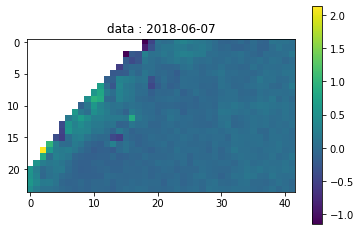

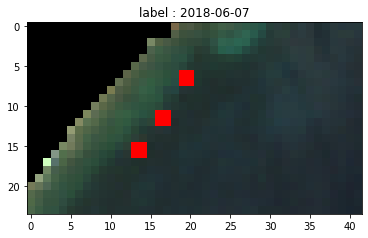

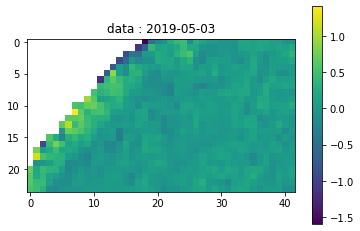

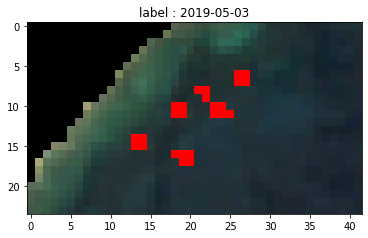

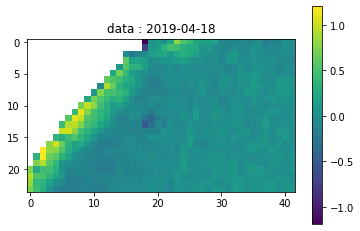

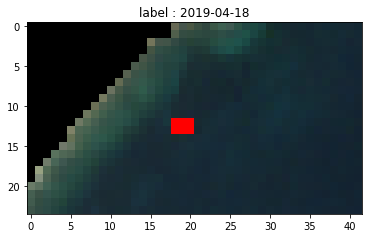

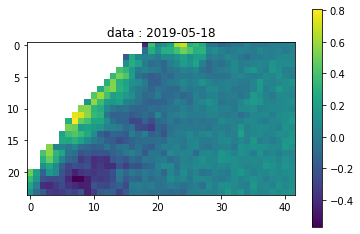

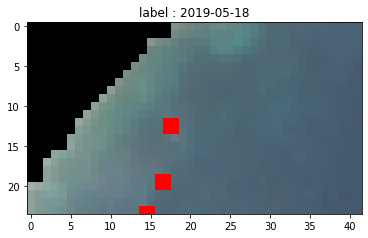

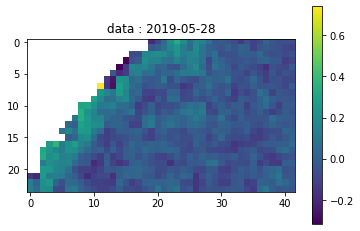

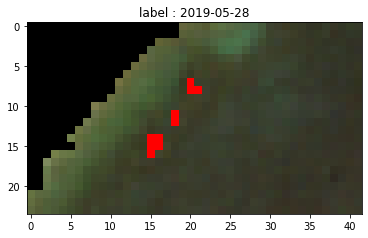

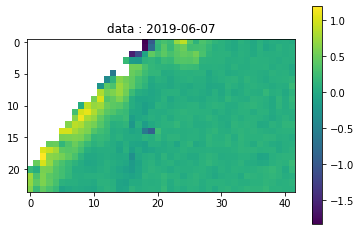

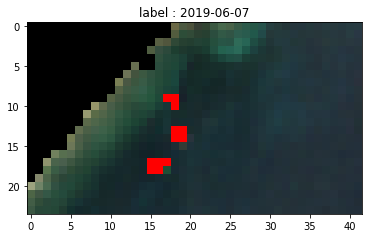

In [7]:

#avec plastique
spectral_sign=np.array([0.051,0.045,0.033,0.039])

test_detection(spectral_sign,methode=CEM)

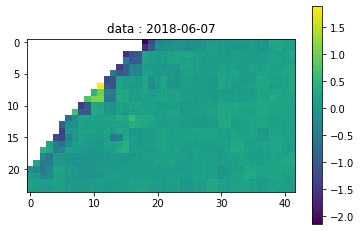

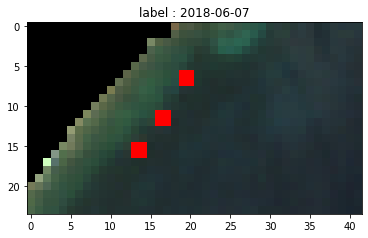

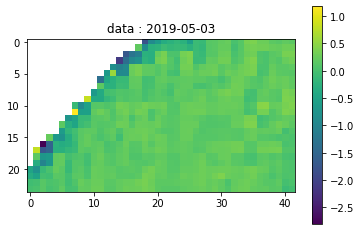

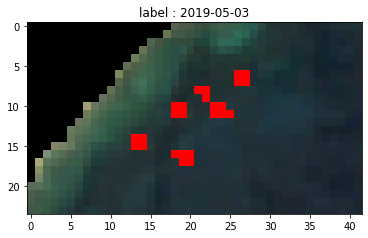

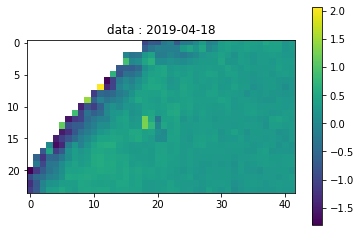

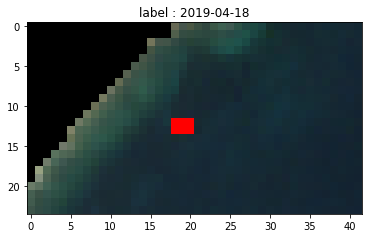

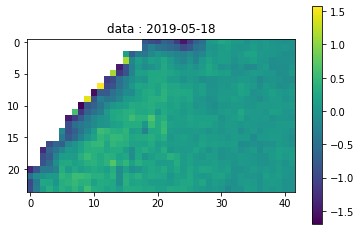

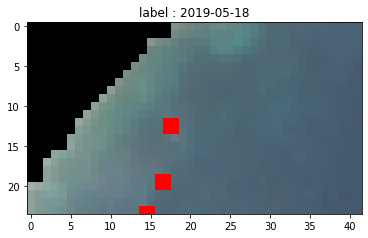

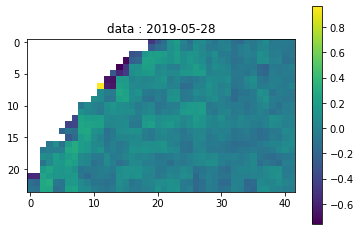

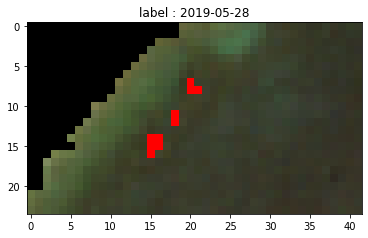

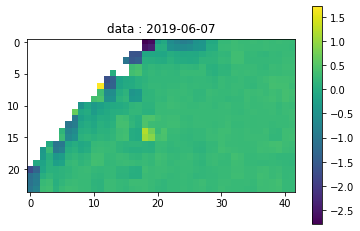

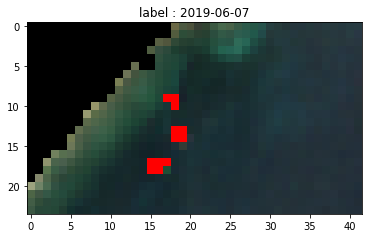

In [8]:
spectral_sign=np.array([0.007,0.018,0.011,0.001])#avec signature spectrale de l'eau turbide
test_detection(spectral_sign,methode=CEM) 

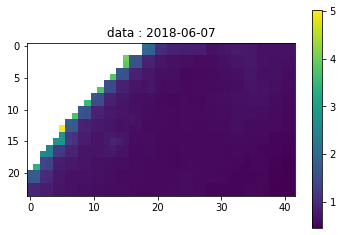

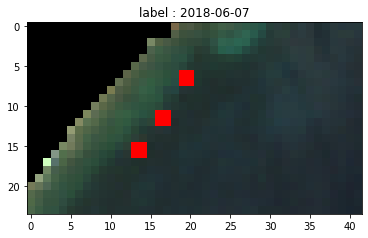

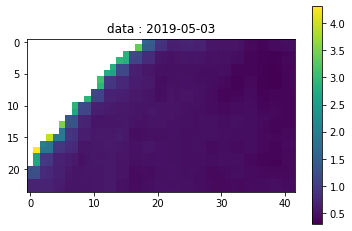

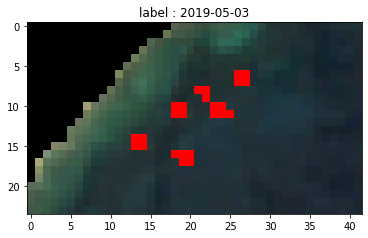

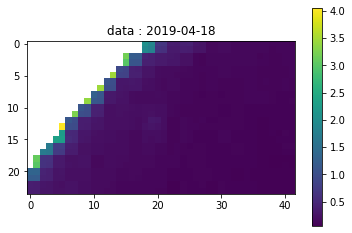

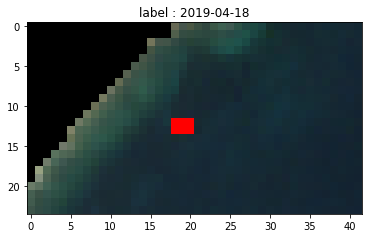

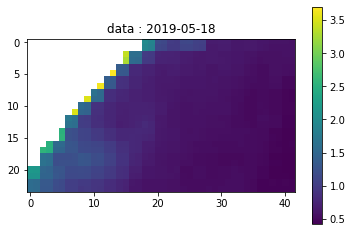

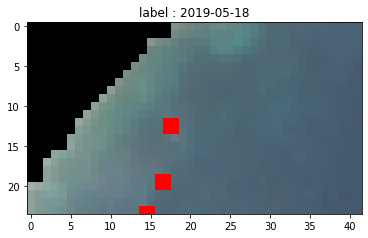

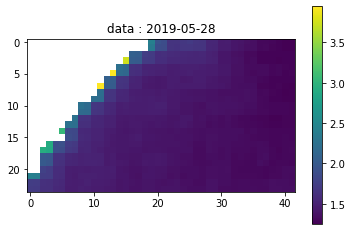

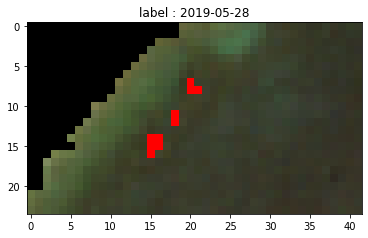

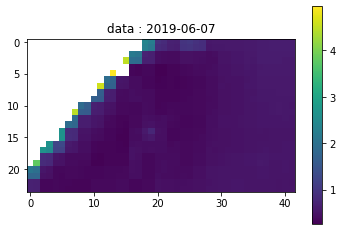

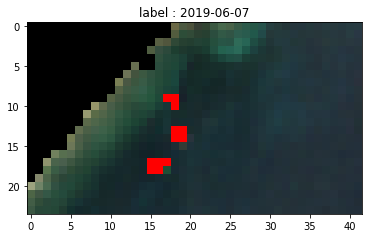

In [42]:
#application de OSP 
def test_OSP():#si spectral sign = -1, on prend le spectral_sign moyen sur une image
    
    spectral_background=np.array([[0.028,0.006,0.001,0.0001],[0.007,0.018,0.011,0.001]])
    spectral_sign=np.array([0.051,0.045,0.033,0.039])
    for i in data.index.unique(level=0):


        image=data.loc[i]

        target=image[["B04","B06","B08","B11"]].dropna()
        
        resultat=OSP(np.array(target),spectral_background,spectral_sign)
        
        plt.figure()
        plt.title("data : "+str(i))
        data.loc[i,"prediction"]=np.array(pd.Series(resultat,index=target.index).reindex(image.index))
        
        to_plot=get_image(data.loc[i],["prediction"])
        plt.imshow(to_plot)
        plt.colorbar()

        plt.figure()
        plt.title("label : "+i)
        to_plot=get_image(data.loc[i],bands)
        plt.imshow(to_plot/max_data)
        to_plot=get_image(data.loc[i],["label"])

        alphas=1*to_plot[:,:]
        plt.imshow(to_plot,alpha=alphas,cmap='rainbow')
test_OSP()

on n'arrive pas a detecter avec Matched filering. En effet, cette algorithme est basée sur l'hypothese qu'on essaye de détecter un signal parmis du bruit, ce qui n'est pas vraiment le cas ici (le plastique ressmemble plus au bruit qu'au signal)

Non-negative Constrained Least Squares (NNLS)


In [50]:
from pysptools.abundance_maps.amaps import NNLS

bands=['B04','B03','B02']
max_data=data[bands].max().max()

def test_LS(endmenber,dic,moyenne=True,methode=NNLS):
    
    for i in data.index.unique(level=0):

        print(i)

        image=data.loc[i]

        target=image[["B04","B06","B08","B11"]].dropna()
        dic[len(endmenber)]="moyenne"
        if moyenne==True:
            spectral_sign=np.append(endmenber,[target.mean()],axis=0)
        else:
            spectral_sign=endmenber
       
        resultat=methode(np.array(target),spectral_sign)
        for k in range(resultat.shape[1]):
                
            plt.figure()
            plt.title("data : "+str(i)+" chanel :"+dic[k])
            data.loc[i,"prediction"]=np.array(pd.Series(resultat[:,k],index=target.index).reindex(image.index))
            
            to_plot=get_image(data.loc[i],["prediction"])
            plt.imshow(to_plot)
            plt.colorbar()

        plt.figure()
        plt.title("label : "+i)
        to_plot=get_image(data.loc[i],bands)
        plt.imshow(to_plot/max_data)
        to_plot=get_image(data.loc[i],["label"])

        alphas=1*to_plot[:,:]
        plt.imshow(to_plot,alpha=alphas,cmap='rainbow')



2018-06-07
2019-05-03
2019-04-18
2019-05-18
2019-05-28
2019-06-07


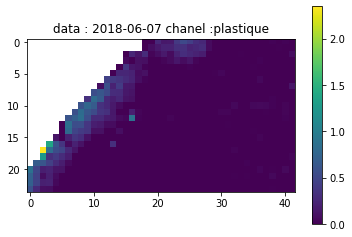

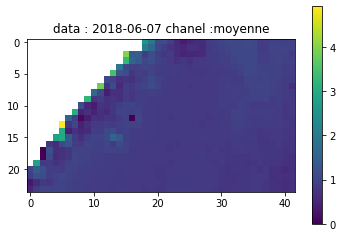

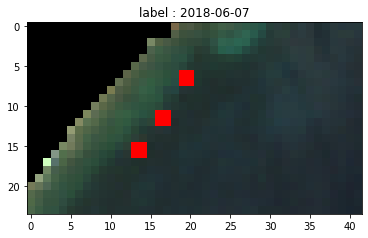

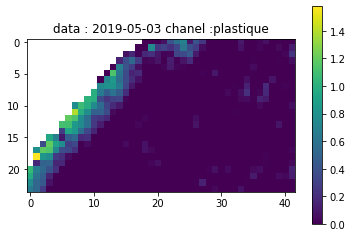

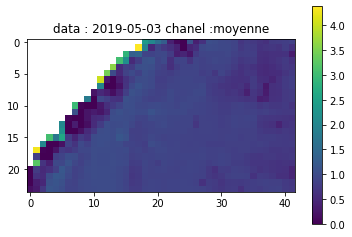

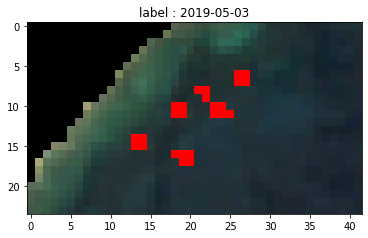

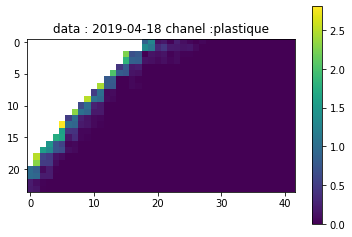

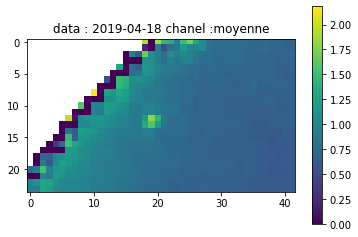

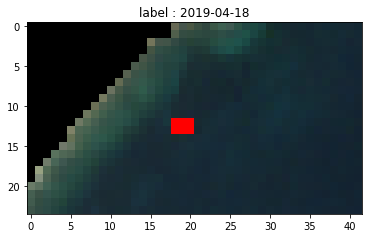

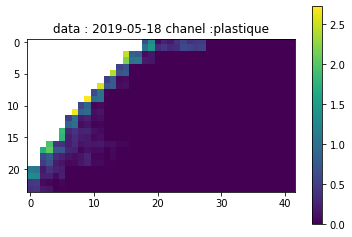

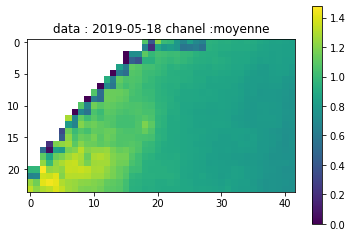

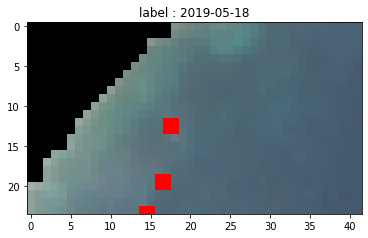

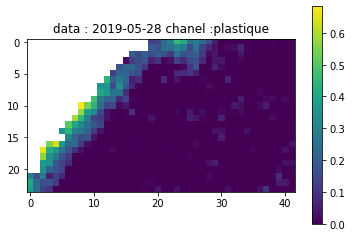

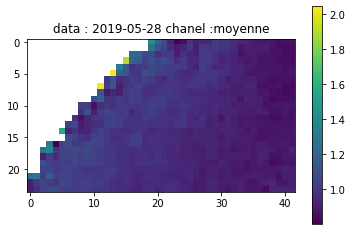

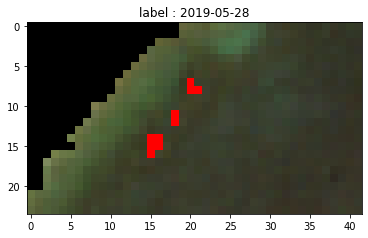

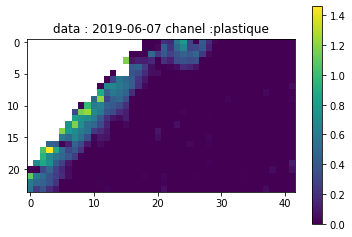

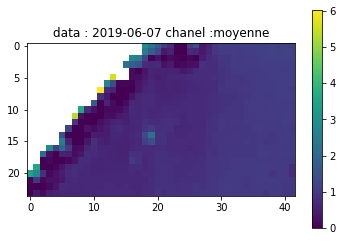

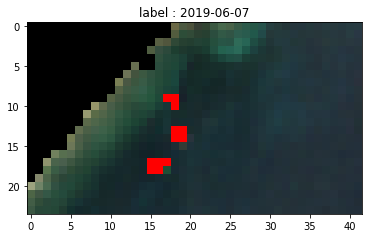

In [46]:
endmenber=np.array([[0.051,0.045,0.033,0.039]])
dic={0:"plastique"}
test_LS(endmenber,dic)

2018-06-07
2019-05-03
2019-04-18
2019-05-18
2019-05-28
2019-06-07
<ipython-input-34-9309d5ce23d9>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


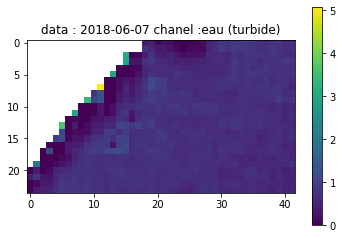

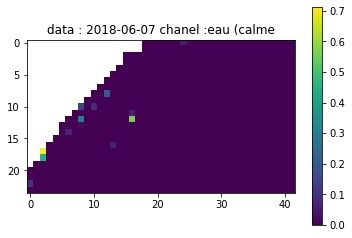

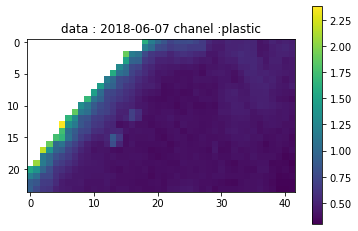

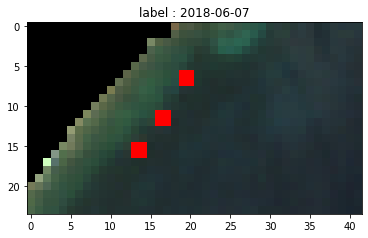

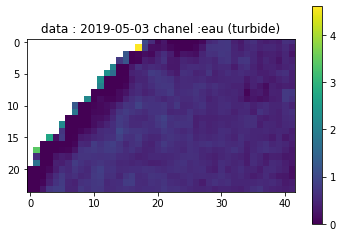

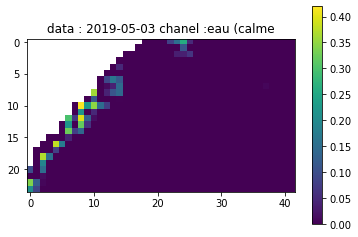

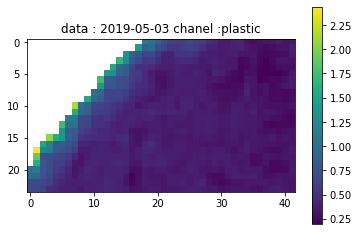

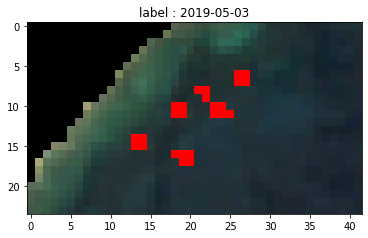

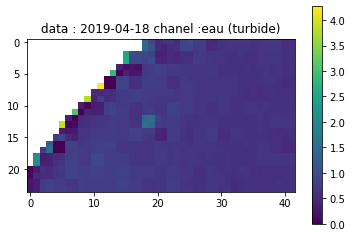

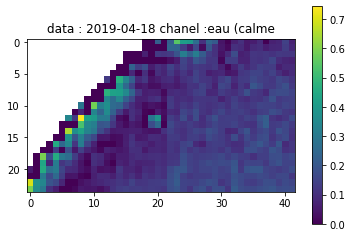

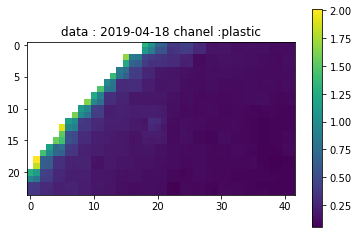

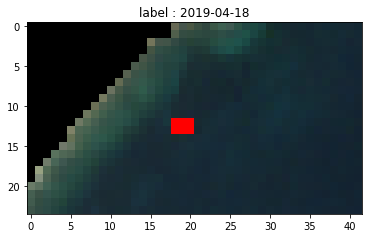

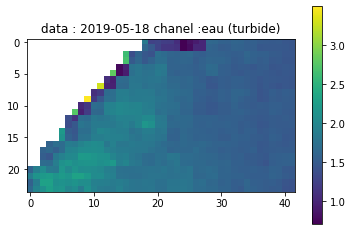

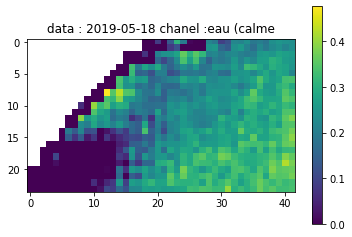

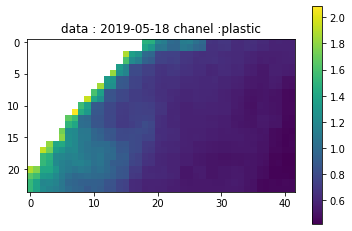

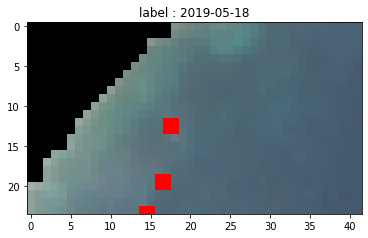

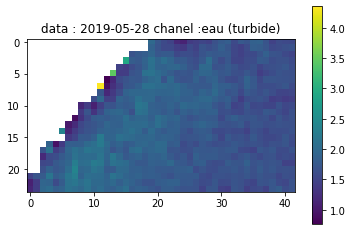

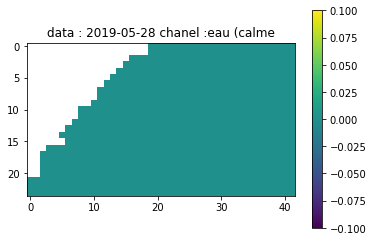

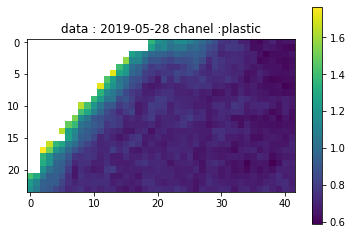

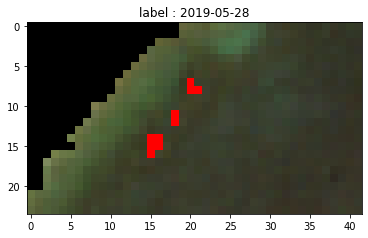

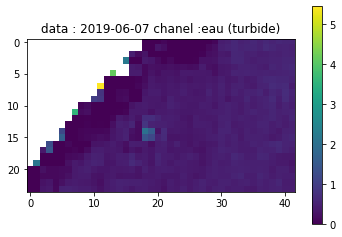

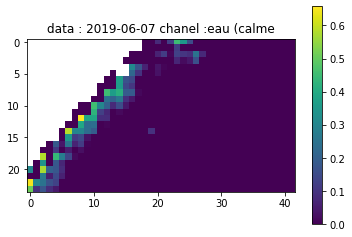

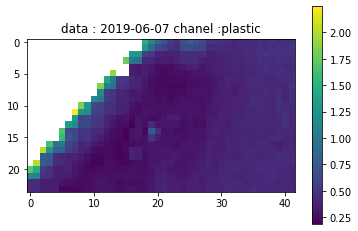

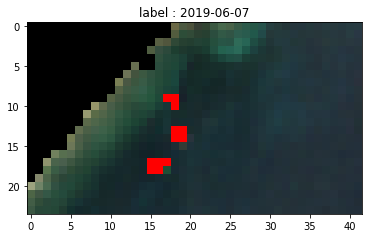

In [37]:
dic={0:"eau (turbide)",1:"eau (calme",2:"plastic"}

spectral_sign=np.array([[0.007,0.018,0.011,0.001],[0.028,0.006,0.001,0.0001],[0.051,0.045,0.033,0.039]])
test_LS(spectral_sign,dic,moyenne=False)

détection bonne avec 2 endmenbers (water +plastic). Mauvaise détéction en général 

-avantage : même si les endmenbers correspondant à l'eau sont de réfelctance plus faible que dans la réalité, on arrive a avoir des résultat grace à la forme des différents pixels. 
-incovegnant : on doit connaitre exactement la forme du plastique. Sinon, la detection ne marche pas (plus mauvaise détection que l'algorithme naïve) La détection est de plus en général mauvaise car on prend pas en compte l'intensité

2018-06-07
2019-05-03
2019-04-18
2019-05-18
2019-05-28
<ipython-input-50-050226086cb5>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
2019-06-07


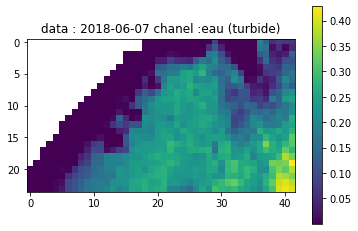

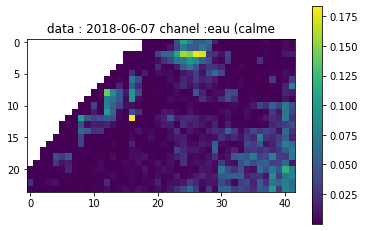

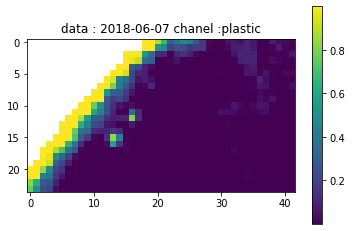

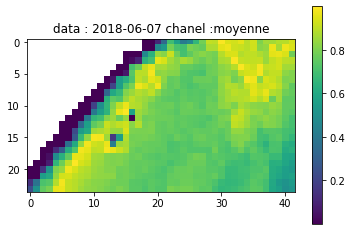

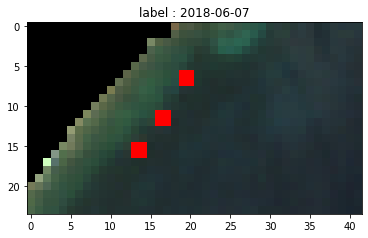

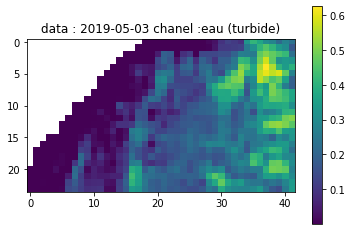

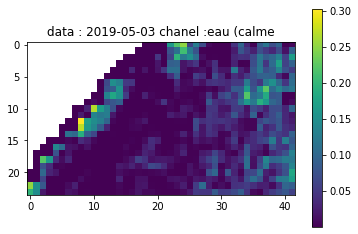

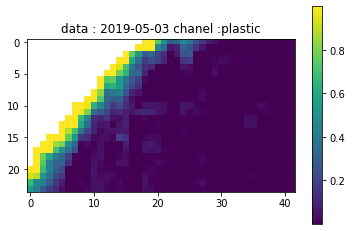

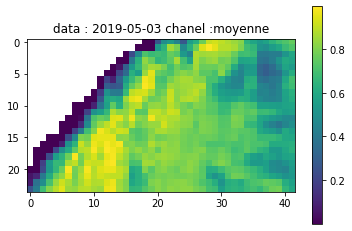

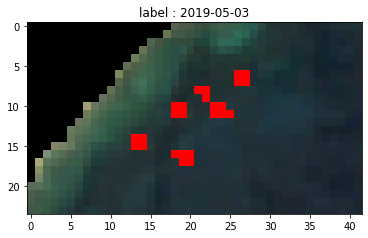

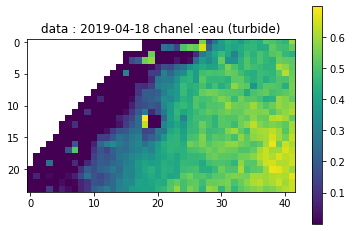

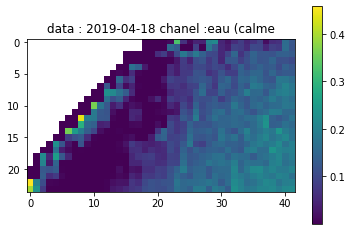

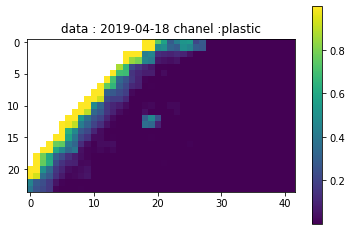

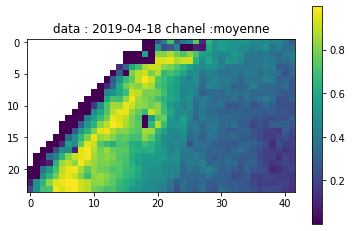

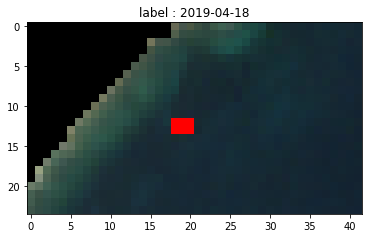

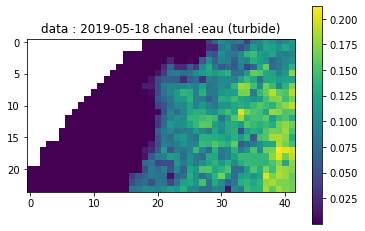

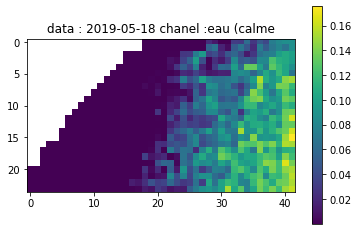

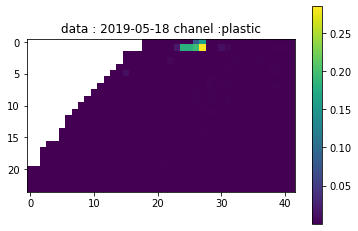

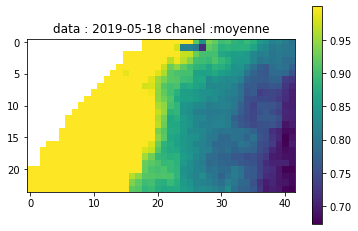

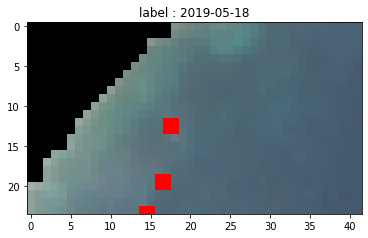

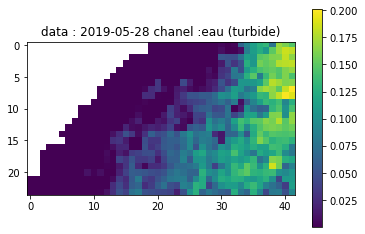

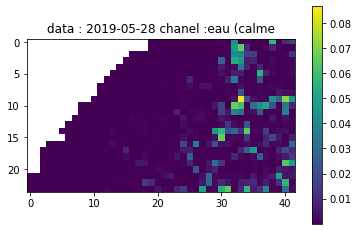

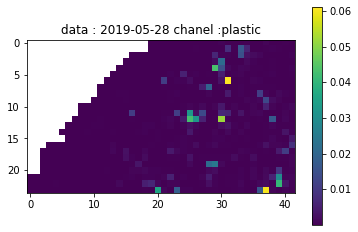

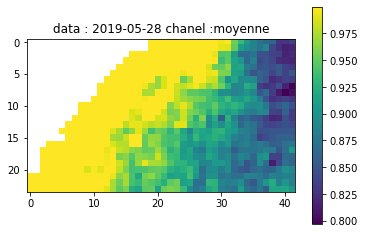

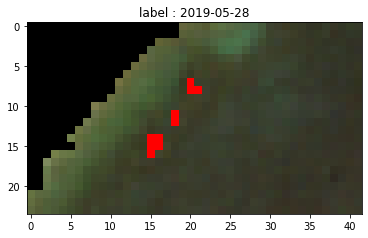

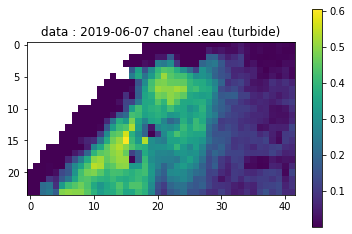

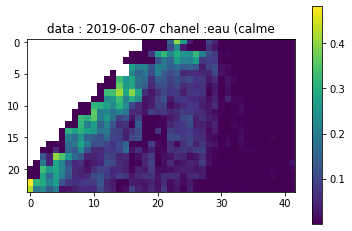

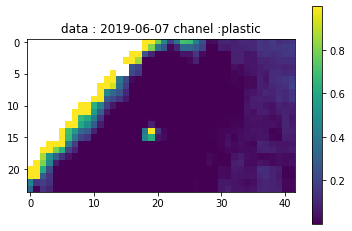

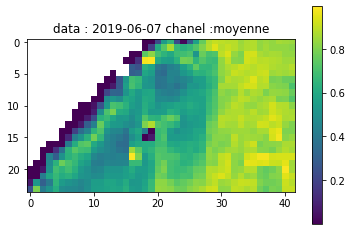

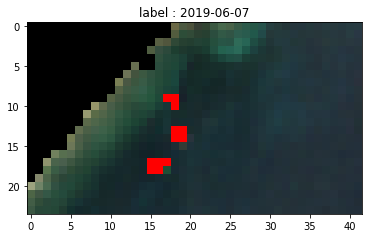

In [52]:
from pysptools.abundance_maps.amaps import FCLS
dic={0:"eau (turbide)",1:"eau (calme",2:"plastic"}

spectral_sign=np.array([[0.007,0.018,0.011,0.001],[0.028,0.006,0.001,0.0001],[0.051,0.045,0.033,0.039]])
test_LS(spectral_sign,dic,methode=FCLS)

avec les bons endmenbers, on arrive a voir une certaine detection du plastique. Il n'y cependant pas suffisant. 